![roses header](https://github.com/fdannemanndugick/roses2021/raw/main/header.png)

# ROSES Unit 9 - Machine Learning

[Omkar Ranadive](https://omkar-ranadive.github.io/)

Applied Scientist,
Alchera Labs

<hr>

## Activity 1 - Introduction to PyTorch 

PyTorch is one of the most widely used frameworks for building Machine Learning models. In this first activity, we will get familiarized with the basics of PyTorch. 

In [1]:
import torch 
import torch.nn.functional as F
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from urllib.request import urlopen 
import pickle 

Pytorch is very similar to Numpy so it's quite easy to get accustomed to PyTorch. Let's look at how to perform a few basic operations in PyTorch and how they are similar to Numpy. 

In [2]:
# Initializing a 3x3 array of ones 
a_np = np.ones((3, 3)) 
a_pt = torch.ones((3, 3))

print(a_np)
print(a_pt)

# Looking up dimensions of the array 
print(a_np.shape) 
print(a_pt.shape)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
(3, 3)
torch.Size([3, 3])


We can see that the output produced by Torch functions is of the data type - "Torch.tensor". Torch tensors are just multi-dimensional matrices. Note that, each tensor array can contain elements of a single data type only (For example - int32, float32 etc). The main difference between PyTorch Tensors and Numpy Arrays is that pytorch tensors can be moved to the GPU for training - this significantly speeds up the computation 

**Note:** For the purpose of this assignment, we will only be using PyTorch CPU to ensure compatibility with everyone's system but in practice you should always use the GPU version if you have GPU access   

In [3]:
# Converting data to tensors 

# Lists can be easily converted to PyTorch tensors 
d = [[1, 2, 3], [4, 5, 6]] 
d_pt = torch.tensor(d)
print(d_pt)

# Numpy arrays can also be easily converted to Torch Tensors 
temp_arr = np.random.rand(3, 5)
print("\nOriginal Numpy array: ")
print(temp_arr)
# Use from_numpy to convert numpy to temp_arr 
temp_arr_pt = torch.from_numpy(temp_arr)
print("\nConverted to Torch Tensor")
print(temp_arr_pt)

# It's just as simple to convert a tensor back to numpy array 
temp_arr = temp_arr_pt.numpy()
print("\nBack to Numpy array")
print(temp_arr)

# To concat multiple arrays together, we can use torch.concat 
print("\nConcat arrays")
concat_arr = torch.cat((temp_arr_pt, a_pt), dim=1)
print(concat_arr.shape)
print(concat_arr)

tensor([[1, 2, 3],
        [4, 5, 6]])

Original Numpy array: 
[[0.4334664  0.97784427 0.47079947 0.08644607 0.95773276]
 [0.95015806 0.21629383 0.02074387 0.87630675 0.09081809]
 [0.61243198 0.54325668 0.32175977 0.43670948 0.71358077]]

Converted to Torch Tensor
tensor([[0.4335, 0.9778, 0.4708, 0.0864, 0.9577],
        [0.9502, 0.2163, 0.0207, 0.8763, 0.0908],
        [0.6124, 0.5433, 0.3218, 0.4367, 0.7136]], dtype=torch.float64)

Back to Numpy array
[[0.4334664  0.97784427 0.47079947 0.08644607 0.95773276]
 [0.95015806 0.21629383 0.02074387 0.87630675 0.09081809]
 [0.61243198 0.54325668 0.32175977 0.43670948 0.71358077]]

Concat arrays
torch.Size([3, 8])
tensor([[0.4335, 0.9778, 0.4708, 0.0864, 0.9577, 1.0000, 1.0000, 1.0000],
        [0.9502, 0.2163, 0.0207, 0.8763, 0.0908, 1.0000, 1.0000, 1.0000],
        [0.6124, 0.5433, 0.3218, 0.4367, 0.7136, 1.0000, 1.0000, 1.0000]],
       dtype=torch.float64)


<hr>

##  Activity 2 - Predicting earthquake arrival time based on station location and earthquake location 

In this activity, we will be developing a neural network which learns a non-linear function to predict earhtquake arrival times. We will be using the example from Unit 7 - Earthquake Location (Section 1). <br> 



#### Credits to Jonathan Smith for the example and for the synthetic data generation code

To recap, the predicted arrival time was defined as follows: 

$t_p^i = T^i(x_i,y_i,z_i,x_s,y_s,z_s, V_H)$    

where $\vec{X}_i=[x_i,y_i,z_i]$ is the station location for station $i$, $\vec{X}_s=[x_s,y_s,z_s]$ the earthquake location, $T$ the travel-time function between the earthquake location and station location dependent on the subsurface velocity structure $V_H$,

Then the misfit function (loss function) was defined as follows: 

$ r = \sum_{i=1}^n |t_o^i - t_p^i|$

where $r$ in this case represents the L1-norm, $n$ represents the total number of station locations, $t_o^i$ the observed arrival time at station location $i$, and $t_p^i$ the predicted arrival time at station location $i$ given in the equation above. 

Then, the observed time values were calculated using the following homogeneous velocity model:  

$T_{V_H}^i = \frac{\sqrt{\left( \vec{X_i}  - \vec{X_s}  \right)^2}}{V_H}$

where $T_V^i$ represents the travel-time for station $i$ dependent on velocity structure $V_H$. Even for this simple case notice the non-linear nature in $T_V^i$ dependent on the source location.

Now, in this activity, we want the neural network to *approximately* learn this non-linear function (homogeneous velocity model). 

Let's see how to go about doing that! 

From the lecture slides, remember the steps in a Machine Learning workflow: 


1. Gather data X, labels Y, define a model M(W) and loss function L(X, Y; W) 
2. Initialize model parameters W 
3. Calculate the loss L w.r.t those parameters 
4. Update the parameters such that loss L is reduced 
5. Keep doing this until convergence  

### Step 1: Gather data X, labels Y, define a model M(W) and loss function L(X, Y; W)




* So, here the data X is the synthetic data which we generate in the next cell (Xc and Xs) 
* The labels Y will be the observed arrival times (to) which are calculated using the homogeneous velocity model 

In [4]:
# ---- Defining the domain of interest. ----/
Xmin,Xmax,Zmin,Zmax = 0,100,-2,10
# X representing the horizontal distance in km
# Z representing the depth positive downwards in km

# ---- Seismic Station Locations ----
n                       = 2000   # Number of seismic stations


# The data X 
Xc      = np.zeros((n,2));
Xc[:,0] = np.random.uniform(low=Xmin, high=Xmax, size=(n))
Xc[:,1] = 0  # Setting stations at surface 

# --- Defining a random source location
Xs =  [np.random.uniform(low=Xmin, high=Xmax),
       np.random.uniform(low=0, high=Zmax)]

In [5]:
# --- Determining the observed travel-times for a single-phase ---
Vh = 3.1 #km/s

# The labels Y 
# Determining the observational Travel-Times assuming origin time t0=0.0
to = np.sqrt(np.sum(np.square(Xc - Xs),axis=1))/Vh

print(to.shape)

(2000,)


Now, using the functions we learned in activity 1, we convert the data to torch tensors 


In [6]:
# Convert to tensors 
Xc_t = torch.from_numpy(Xc)
Xs_t = torch.tensor(n*[Xs])

"""
Note, how I am converting y and the data variable to .float().
A PyTorch model expects the input data to be in float32 by default. A numpy array is float64 (double) by default. 
Hence, always remember to apply the proper conversions beforehand! 
"""  

Y = torch.from_numpy(to).reshape(-1, 1).float()

print(Xc_t.shape, Xs_t.shape, Y.shape)

# Concatenate them together 
X = torch.cat((Xc_t, Xs_t), dim=1).float()
print(X.shape)

torch.Size([2000, 2]) torch.Size([2000, 2]) torch.Size([2000, 1])
torch.Size([2000, 4])


Next, we define our model. 

* Models in PyTorch can be defined as classes in Python 
* We need to inherit the torch.nn.Module (include it in the class definition; eg - class FCN(**torch.nn.Module**) 
* Next, the model structure is defined in the def __init__ function. A simple fully connected linear layer can be defined using the nn.Linear function. The first value is the incoming features (4) and the second value is the outgoing features (8). 
* Every PyTorch class needs to have a forward function - this is equivalent to the forward pass of the model. The different components which we defined in the model structure (init function) are used in this forward function. Also, note that we are passing the output of each component through non-linear functions wherever required (Ex - F.Relu(self.fc1(x)))


So, a model defined below would look as follows: 

<img src="https://i.imgur.com/IVl1Toz.png" width="450" height="650" />

Here the four input features are the 2d co-ordinates for a station and the 2d co-ordinates of the earthquake  

The nn.Linear function in more details: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

Just like nn.linear, there are a host of other functions inside the torch.nn module: https://pytorch.org/docs/stable/nn.html

So, while the math may seem intimidating, it's pretty easy to build these models in practice using these functions! 

In [7]:
class FCN(torch.nn.Module): 
    def __init__(self):
        super(FCN, self).__init__()
        
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 1)
    
    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x 


Next, we can define our loss (misfit) function 

In [8]:
loss_fn = nn.L1Loss(reduction='mean')

### 2. Initialize model parameters W 

In [9]:

# The model parameters get initialized by creating an instance of the class 
model = FCN()

# Learning rate controls the rate of learning (how much should we react to the gradient signal)
learning_rate = 1e-4

# Optimizers basically optimize the gradient descent learning process. 
# One of the most widely used optimizer is Adam's Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


**Bonus:** For those interested in further reading on optimizers, here's a really nice blog post (credits to Sebastian Ruder) <br>
https://ruder.io/optimizing-gradient-descent/

### 3. Calculate the loss L w.r.t those parameters 
### 4. Update the parameters such that loss L is reduced 
### 5. Keep doing this until convergence  

In [10]:
# Step 3,4 and 5 are done by this simple piece of code! 

# The number of epochs determine how many times do we want to go over the entire data 
# Learning stops once the maximum number of epochs are reached 
epochs = 10000 

for i in range(epochs): 
    # Get output from the model (predicted arrival times for all stations)
    y_pred = model(X) 
    
    # This is step 3 - Calculating the loss 
    loss = loss_fn(y_pred, Y)
        
    if i % 500 == 0: 
        print("Loss", loss.item())
        
    
    # The optimizer by default accumulates gradient. 
    # So remember to call optimizer.zero_grad() as we only want to run the backward pass w.r.t the current gradient signal 
    
    optimizer.zero_grad()
    # loss.backward() will calculate the gradient w.r.t all parameters 
    loss.backward()
    # Optimizer.step() will perform the actual parameter update 
    optimizer.step()


Loss 20.353666305541992
Loss 14.781240463256836
Loss 4.25840950012207
Loss 2.1638262271881104
Loss 1.1960673332214355
Loss 0.922408938407898
Loss 0.9017630815505981
Loss 0.8782573938369751
Loss 0.8514451384544373
Loss 0.8216419219970703
Loss 0.7890579700469971
Loss 0.7546191811561584
Loss 0.719515860080719
Loss 0.6838544607162476
Loss 0.6464371681213379
Loss 0.6051987409591675
Loss 0.5549943447113037
Loss 0.4897640347480774
Loss 0.40860724449157715
Loss 0.33446192741394043


In [11]:

print("Actual values: {}".format(Y[:100].squeeze()))
print("Predicted values: {}".format(y_pred[:100].squeeze()))

Actual values: tensor([20.5150, 14.9283,  1.5215, 12.8255, 11.9655,  1.5252, 20.0285, 19.1101,
        22.0059, 22.4280,  7.6533, 14.6970,  9.8511,  1.6910, 22.1209, 10.5172,
        12.6010,  5.4782,  1.5273,  1.5281,  9.2691, 15.8773,  5.7548, 21.3359,
         2.4332, 14.5305, 14.7304, 12.5884, 17.6553,  5.6469,  3.9749, 12.7202,
        22.8519,  8.7630, 12.0334, 22.5246,  4.6265,  7.1296,  3.3267,  2.6720,
        11.1655, 19.2272,  5.9774, 19.8006, 14.4181, 21.0068, 19.2288,  8.1451,
        19.0283, 11.9827,  6.3646,  5.7040,  8.9154, 10.7793,  4.3236, 18.7557,
         5.6897,  7.1795,  5.4772,  1.8681,  1.9838, 18.6842,  1.5275, 21.6485,
         7.4851, 22.3479,  2.2078,  3.6950,  8.5902,  2.9629,  5.7023, 15.2753,
        23.3296, 15.0137,  7.5774,  5.2557, 17.0630,  8.3527, 14.9470,  5.2578,
        22.2779,  2.9140, 18.6292,  2.0692,  6.2051,  1.5802, 11.3485, 18.4144,
         4.4680, 15.3148,  2.5473,  8.7696,  1.6700,  3.7730,  3.5310,  7.7631,
         2.1796, 11.1365,

So, we can see from the results printed above that our simple neural network was able to approximate the arrival times pretty well! 



### Bonus Activity

Try changing the value of learning rate in the initialize model parameters step. What do you observe for the following scenarios? 

* What happens to the loss when you making the learning rate progressively larger (1e-2, 1e-1, 0.2, 0.3 etc) 

* What happens to the loss when you use a smaller learning rate? (1e-5, 1e-6 etc) 

<hr> 

## Activity 3 - Classifying Earthquake and Noise Signals 

In this activity, we will be building a CNN classifier to classify between Earthquake Signals and Noise Signals (background noise). We will be using data from [Earthquake Detective](https://www.zooniverse.org/projects/vivitang/earthquake-detective). 

We will be attempting to classify between Earthquake and Noise using images alone. This works in this case as the data is clean and most of the earthquake images have clear distinguishable characteristics from noise images. 

In [12]:
X_img = pickle.load(urlopen("https://www.dropbox.com/s/s3jy5cc6wcd5i9c/X_img?dl=1"))
Y = pickle.load(urlopen("https://www.dropbox.com/s/zvzemxjfodggbwq/Y?dl=1"))

In [13]:
# There are 820 data samples 
print(len(X_img), len(Y))

print(X_img[0][0].shape)

820 820
(135, 334)


Every sample is made of three grayscale images representing the Earthquake/Noise signal across three channels - BHZ, BHE, BHN

Examples are shown below: 

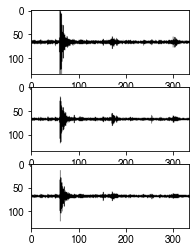

In [14]:
# Example of an Earthquake across three channels (BHZ, BHE, BHN)

fig, axes = plt.subplots(3)

axes[0].imshow(X_img[50][0], cmap='gray')
axes[1].imshow(X_img[50][1], cmap='gray')
axes[2].imshow(X_img[50][2], cmap='gray')

plt.show()


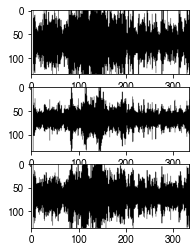

In [15]:
# Example of noise 

fig, axes = plt.subplots(3)

axes[0].imshow(X_img[38][0], cmap='gray')
axes[1].imshow(X_img[38][1], cmap='gray')
axes[2].imshow(X_img[38][2], cmap='gray')

plt.show()

Remember from the slides that we should divide our data into train and test sets. In the code cell below, we randomly choose 80% of the data samples for training and pass the remaining 20% for testing. 

In [16]:
X_img = np.array(X_img)
Y = np.array(Y)

X = torch.from_numpy(X_img).float()
Y = torch.from_numpy(Y).long()

n = X_img.shape[0]

# Shuffle the values and divide into train and test 
permut = np.random.permutation(n)

train_percent = 0.8 
train_samples = int(train_percent * n)
test_samples = n - train_samples 
print("Number of train samples {} and Number of test samples {}".format(train_samples, test_samples))
X_train, Y_train = X[permut[:train_samples], ], Y[permut[:train_samples]]
X_test, Y_test = X[permut[train_samples:], ], Y[permut[train_samples: ]]
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Number of train samples 656 and Number of test samples 164
torch.Size([656, 3, 135, 334]) torch.Size([656]) torch.Size([164, 3, 135, 334]) torch.Size([164])


Now, we follow the same steps as the previous activity to build and train our model 

Remember from the lecture slides, the model structure for a CNN looks like follows: 

<img src="https://i.imgur.com/AYASYvA.png" width=600 height=300>

In [17]:
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, kernel_size=(5, 5), stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=(3, 3), stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        self.fc1 = nn.Linear(3264, 512) 
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        # print("Shape after flattening", x.shape)
        
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        
        return x 
        
        

        


It's important to note that there is no fixed way to decide the values used while defining a model. For example, in the code cell above in self.conv1, we took the 3 grayscale images and outputted 8 filters (channels) with kernel size = 5 and stride 2. But one could have also outputted some other number of channels like 12 or 16 and used a different kernel size. **It's mostly trial and error**. A good strategy is to look up how other researchers have built existing models on similar kind of data and then try to work from there.  


### Important trick to determine to determine the number of features going into a fully connected network. 


In the model which we defined in the previous cell, you can see that I have put the number of features going into the first fully connected layer (self.fc1) as 3264. This number comes after flattening the features received from the previous layer. But how to easily determine this number? 

So, the long way of calculating this number is to follow the mathematical formula shown in the PyTorch documentation for each CNN module. However, an easier way is to just print the shape of the data after flattening it out. 

We can quickly test this by doing a single pass of the model with our data and print the shape after flattening. 
So, for example, if you uncomment the print statement in the previous cell and run the following cell you get the number of features after flattening. 

In [18]:
model = CNN()
# Run a single pass of the model 
model(X) 

# The print statement should give [820, 3264] 
# Now, that we know the flattened features = 3264, we can set nn.Linear(3264, 512)

# Make sure to comment out the print statement again before moving forward to avoid unnnecessary prints in future cells 

tensor([[0.4876, 0.5124],
        [0.4824, 0.5176],
        [0.4831, 0.5169],
        ...,
        [0.4751, 0.5249],
        [0.4757, 0.5243],
        [0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)

In [19]:
model = CNN()
# Cross entropy loss is commonly used for classification tasks: 
# Link: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
epochs = 50 

for i in range(epochs): 
    y_pred = model(X_train) 
    
    loss = loss_fn(y_pred, Y_train)
    
    
    if i % 5 == 0: 
        print("Loss", loss.item())
        
        _, predicted = torch.max(y_pred, 1)
        correct_mat = (predicted == Y_train).squeeze()
        correct_count = torch.sum(correct_mat).item()
        print("Train Accuracy: {}".format(correct_count/len(predicted)))
        
        with torch.no_grad(): 
            y_pred_test = model(X_test)
            _, predicted = torch.max(y_pred_test, 1)
            correct_mat = (predicted == Y_test).squeeze()
            correct_count = torch.sum(correct_mat).item()
            print("Test Accuracy: {}".format(correct_count/len(predicted)))

        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Loss 0.6914015412330627
Train Accuracy: 0.5884146341463414
Test Accuracy: 0.5548780487804879
Loss 0.686665415763855
Train Accuracy: 0.6722560975609756
Test Accuracy: 0.6341463414634146
Loss 0.6824972629547119
Train Accuracy: 0.6646341463414634
Test Accuracy: 0.6036585365853658
Loss 0.6787773370742798
Train Accuracy: 0.663109756097561
Test Accuracy: 0.6036585365853658
Loss 0.6753522157669067
Train Accuracy: 0.6676829268292683
Test Accuracy: 0.6036585365853658
Loss 0.6720756888389587
Train Accuracy: 0.6722560975609756
Test Accuracy: 0.6097560975609756
Loss 0.6689049601554871
Train Accuracy: 0.6737804878048781
Test Accuracy: 0.6097560975609756
Loss 0.6658105850219727
Train Accuracy: 0.6737804878048781
Test Accuracy: 0.6219512195121951
Loss 0.6627728343009949
Train Accuracy: 0.6798780487804879
Test Accuracy: 0.6463414634146342
Loss 0.6598311066627502
Train Accuracy: 0.6798780487804879
Test Accuracy: 0.6524390243902439


<hr>

**Note:** As the model parameters are randomly initialized and as the dataset is randomly split between train and test, the accuracies will vary in different runs. In practice, this is fine as long as the variance is small over different runs of the model. 

## Activity 4 (Bonus) - Classifiying between Earthquake and Noise signals directly using the signal data

In this activity, we will be using data from the [Stanford Earthquake Dataset (STEAD)](https://github.com/smousavi05/STEAD). 

I have already processed and taken a subset of that dataset which contains 5000 noise signals and 5000 earthquake signals. 

**The task:** Just like activity 3, you have to build a CNN model and then train it. **But remember, now it's only 1D data (signal) so you would use 1D convolutions instead of 2D.**

Solution will be provided separately later on. 

In [21]:
# May take some time to download 
X_noise = pickle.load(urlopen("https://www.dropbox.com/s/pzlvpwfc3ext7ob/X_noise?dl=1"))
X_eq = pickle.load(urlopen("https://www.dropbox.com/s/h6fgk5mf1alie1u/X_Eq?dl=1"))

In [22]:
X_noise = np.array(X_noise)
X_eq = np.array(X_eq)

# Create a label array, noise = 0, eq = 1
Y_noise = np.zeros(X_noise.shape[0])
Y_eq = np.ones(X_eq.shape[0])

print(X_noise.shape, X_eq.shape, Y_noise.shape, Y_eq.shape)

(5000, 6000, 3) (5000, 6000, 3) (5000,) (5000,)


In [23]:
# Convert to torch tensors and concat 
X_noise = torch.from_numpy(X_noise)
X_eq = torch.from_numpy(X_eq)
Y_noise = torch.from_numpy(Y_noise)
Y_eq = torch.from_numpy(Y_eq)

X = torch.cat((X_noise, X_eq), dim=0).float()
Y = torch.cat((Y_noise, Y_eq), dim=0).long()

# Pytorch models require input of the form -> Number of examples, Channels, features 
# So, swap the dimensions to make sure the input is in correct form 
X = torch.transpose(X, 1, 2)

print(X.shape, Y.shape)


torch.Size([10000, 3, 6000]) torch.Size([10000])


In [24]:
# Shuffle the values and divide into train and test 
n = X.shape[0]
permut = np.random.permutation(n)

train_percent = 0.8 
train_samples = int(train_percent * n)
test_samples = n - train_samples 
print("Number of train samples {} and Number of test samples {}".format(train_samples, test_samples))
X_train, Y_train = X[permut[:train_samples], ], Y[permut[:train_samples]]
X_test, Y_test = X[permut[train_samples:], ], Y[permut[train_samples: ]]
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Number of train samples 8000 and Number of test samples 2000
torch.Size([8000, 3, 6000]) torch.Size([8000]) torch.Size([2000, 3, 6000]) torch.Size([2000])



**Start your code from here onward**

To do: 

1. Build a CNN class like in the previous activity 
2. Train the model and check the accuracy on the training and testing set 

Functions to refer to while building the CNN model: 
* Conv 1D: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
* Max Pool 1D: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html
* NN Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html


Additional notes: 
* Remember the model is 1D, so use a single integer for kernel_size instead of a 2D tuple which was used in the previous activity 
* Use the trick mentioned in the previous activity to determine the incoming number of features to a nn.Linear layer 




## Solution 

## Conclusion 

We learned the basics of neural networks in this tutorial. For further reading, I would recommend going through the different tutorials available on the PyTorch website: https://pytorch.org/tutorials/